In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Notebook 1: Introduction

This notebook serves to show how to implement a simple neural network model from scratch, and how to train and evaluate it. Only numpy is used.


## The dataset (MNIST)
In this step, we load and visualize the dataset. We also have to preprocess it a bit.

### Loading the data
First, we load the data from the provided .csv-files. The csv-files consist of one row per datapoint, the first entry being the target class (digit) and the 784 (which equals 28x28). The other entries are row-wise linearized grayscale pixels of the respective image with values between 0 and 255.

In [2]:
import csv

def read_csv(filepath, delimiter=","):
    """Read csv file from filepath.
    
    Keyword arguments:
        filepath(str) -- filepath of the csv file.
    Returns:
        (train_data(float), train_label(int)) -- tuple of train_data and train_label.
    """
    with open(filepath, newline="\n") as csvfile:
        csvfile = csv.reader(csvfile, delimiter=delimiter)
        data = np.array([r for r in csvfile])
        train_data = data[:, 1:].astype("float")
        train_label = data[:, 0].astype("int")
    return train_data, train_label
    

# Train data:
data_train_x, data_train_y = read_csv("sample_data/mnist_train_small.csv")

# Test data:
data_test_x, data_test_y = read_csv("sample_data/mnist_test.csv")

### Inspecting the data

Now, we can inspect our data and check it shapes

data_train_x.shape: (20000, 784)
data_train_y.shape: (20000,)
data_test_x.shape: (10000, 784)
data_test_y.shape: (10000,)
Label: 7


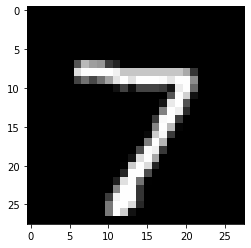

In [3]:
# Shape of the datasets:
print(f"data_train_x.shape: {data_train_x.shape}")
print(f"data_train_y.shape: {data_train_y.shape}")
print(f"data_test_x.shape: {data_test_x.shape}")
print(f"data_test_y.shape: {data_test_y.shape}")

# Picturing the first entry of the test dataset:
x0 = data_test_x[0]
y0 = data_test_y[0]
print(f"Label: {y0}")

x0_reshaped = x0.reshape((28, 28))
plt.imshow(x0_reshaped, cmap="gray")

### Preprocessing the data
For preprocesssing, we divide each grayscale value by 255 and standardize the dataseet. Also, we transform the target labels into one-hot encodings.

In [4]:
data_train_x /= 255
data_test_x /= 255

data_x = np.concatenate((data_train_x, data_test_x))
mean = np.mean(data_x)
std = np.std(data_x)

# Standardization:
data_train_x = (data_train_x - mean) / std
data_test_x = (data_test_x - mean) / std

# One-hot encode labels:
label_size = 10
data_train_y_one_hot = np.eye(label_size)[data_train_y]
data_test_y_one_hot = np.eye(label_size)[data_test_y]

In [5]:
data_test_y[0], data_test_y_one_hot[0]

(7, array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

## The model: a simple Multi-layer perceptron (MLP)

![mlp_model_sketch.png](mlp_model_sketch.png)

<br>

### The easiest parts first!
To start off, let's implement sigmoid and softmax.

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exps = np.exp(z - z.max())
    return exps / (np.sum(exps, axis=0))

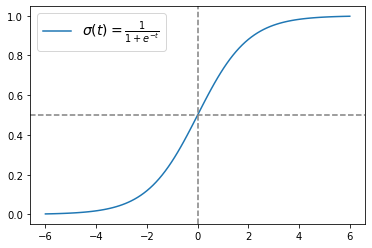

In [7]:
z = np.linspace(-6, 6, 100)
plt.plot(z, sigmoid(z), label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.axvline(x=0, color="gray", linestyle="--")
plt.axhline(y=0.5, color="gray", linestyle="--")
plt.legend(fontsize=14);

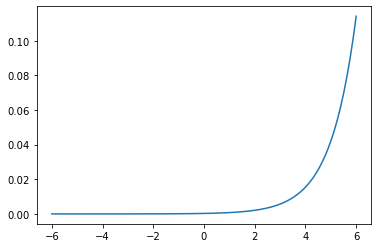

In [8]:
z = np.linspace(-6, 6, 100)
plt.plot(z, softmax(z));

## Training a Feed-forward Network

### Begining the model class
Now we should begin writing the model class. We will do this step by step and add functions as we go, with explanations in-between.

In [9]:
class FFN():
    """A feed-forward network model class."""
    
    def __init__(self, sizes=[784, 128, 64, 10], epochs=10, lr=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.lr = lr
        
        # Initialize model parameters:
        self.params = self.initialize_parameters()

### Setting up the network: Initialization
We must guarantee that the initial parameters (the weights) have some variation in them to facilitate learning. For more details, see [this blog post](https://towardsdatascience.com/neural-network-breaking-the-symmetry-e04f963395dd). It also explains the specific form of initialization we are using called Xavier initialization.

In [10]:
def initialize_parameters(self):
        input_layer = self.sizes[0]
        hidden_layer_1 = self.sizes[1]
        hidden_layer_2 = self.sizes[2]
        output_layer = self.sizes[3]
        
        # Xavier initialization
        params = {
            "W1": np.random.randn(hidden_layer_1, input_layer) * np.sqrt(1. / hidden_layer_1),
            "W2": np.random.randn(hidden_layer_2, hidden_layer_1) * np.sqrt(1. / hidden_layer_2),
            "W3": np.random.randn(output_layer, hidden_layer_2) * np.sqrt(1. / output_layer),
        }
        print(f"Initialized! Total parameters: {np.prod(params['W1'].shape)+np.prod(params['W2'].shape)+np.prod(params['W3'].shape)}")
        return params

FFN.initialize_parameters = initialize_parameters

### Inplementing the forward pass
Now, we have everything we need to implement a forward pass.

![mlp_model_sketch.png](mlp_model_sketch.png)

In [11]:
def forward(self, x_train):
    params = self.params
    
    # The first activations should just be the input sample:
    params["A0"] = x_train # x_train is of shape (784, )
    
    # Input layer to hidden layer 1:
    params["z1"] = np.dot(params["W1"], params["A0"])
    params["A1"] = sigmoid(params["z1"])
    
    # Hidden layer 1 to hidden layer 2:
    params["z2"] = np.dot(params["W2"], params["A1"])
    params["A2"] = sigmoid(params["z2"])
    
     # Hidden layer 2 to output layer:
    params["z3"] = np.dot(params["W3"], params["A2"])
    params["A3"] = softmax(params["z3"])
    
    return params["A3"]

FFN.forward = forward

### Evaluating the model:
We can now also write some code to evaluate the accuracy of our model on some data.

In [12]:
def accuracy(self, data_x, data_y):
    predictions = []
    
    for x, y in zip(data_x, data_y):
        output = self.forward(x)
        pred = np.argmax(output)
        predictions.append(pred == y)
    return np.mean(predictions)

FFN.accuracy = accuracy

### Sanity check: performance of a random network
To test the code that we have so far, we can initialize our model with random weights, and compute the accuracy on the MNIST training dataset. Since we haven't trained it, we expect an accuracy of somewhere around 10% since there are 10 classes in our dataset. The concrete value depends on the initialization, which is random.

In [13]:
model = FFN()
accuracy = model.accuracy(data_train_x, data_train_y)
print(f"Accuracy = {accuracy*100:02f}%")

Initialized! Total parameters: 109184
Accuracy = 9.805000%


### Backpropagation
Next, we should implement the function that allows us to compute the gradients of the loss w.r.t the weights. Before that, we have to derive and implement the derivative of sigmoid and softmax!

In [14]:
def sigmoid_derivative(x):
    return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)

def softmax_derivative(x):
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))


In [15]:
def backward(self, data_y, predictions):
    params = self.params
    change_w = {}
    
    # Calculate W3 update:
    error = 2 * (predictions - data_y) * softmax_derivative(params["z3"])
    change_w["W3"] = np.outer(error, params["A2"])
    
    # Calculate W2 update:
    error = np.dot(params["W3"].T, error) * sigmoid_derivative(params["z2"])
    change_w["W2"] = np.outer(error, params["A1"])
    
    # Calculate W1 update:
    error = np.dot(params["W2"].T, error) * sigmoid_derivative(params["z1"])
    change_w["W1"] = np.outer(error, params["A0"])
    
    return change_w

FFN.backward = backward

In [16]:
def update_network_parameters(self, changes_to_w):
    for key, value in changes_to_w.items():
        self.params[key] -= self.lr * value
FFN.update_network_parameters = update_network_parameters

### Training loop
finally, we can tie everything together by writing a training loop:

In [17]:
def train(self, data_x, data_y):
    for epoch in range(self.epochs):
        accuracy = self.accuracy(data_x, np.argmax(data_y, axis=1))
        print(f"Epoch: {epoch:d}, Train accuracy = {accuracy*100:.2f}")
        
        for x, y in zip(data_x, data_y):
            output = self.forward(x)
            changes_to_w = self.backward(y, output)
            self.update_network_parameters(changes_to_w)

FFN.train = train

### Executing the training:
Let's create a model object and train it for a bit, then evaluate its accuracy on the test set.

In [18]:
model = FFN(epochs=10, lr=0.01)
model.train(data_train_x, data_train_y_one_hot)

print()
accuracy = model.accuracy(data_test_x, data_test_y)
print(f"Test accuracy = {accuracy*100:.2f}%")

Initialized! Total parameters: 109184
Epoch: 0, Train accuracy = 11.91
Epoch: 1, Train accuracy = 82.71
Epoch: 2, Train accuracy = 91.09
Epoch: 3, Train accuracy = 92.80
Epoch: 4, Train accuracy = 93.88
Epoch: 5, Train accuracy = 94.53
Epoch: 6, Train accuracy = 95.03
Epoch: 7, Train accuracy = 95.44
Epoch: 8, Train accuracy = 95.78
Epoch: 9, Train accuracy = 96.09

Test accuracy = 93.88%


## Doing the same in PyTorch

In [19]:
# !conda install --y -c pytorch pytorch torchvision

In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

/Users/s3nsei/miniconda3/envs/ml22/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/s3nsei/miniconda3/envs/ml22/lib/python3.9/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: /Users/s3nsei/miniconda3/envs/ml22/lib/python3.9/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 15.0.0 or later, but libjpeg.9.dylib provides version 14.0.0
  warn(f"Failed to load image Python extension: {e}")


In [21]:
train_dataset = datasets.MNIST(root="./data",
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)

test_dataset = datasets.MNIST(root="./data",
                              train=False,
                              transform=transforms.ToTensor())

In [22]:
class TorchFFN(nn.Module):
    def __init__(self, sizes=[784, 128, 64, 12]):
        super().__init__()
        
        fc1 = nn.Linear(sizes[0], sizes[1])
        fc2 = nn.Linear(sizes[1], sizes[2])
        fc3 = nn.Linear(sizes[2], sizes[3])
        self.layers = nn.Sequential(
            fc1,
            nn.Sigmoid(),
            fc2,
            nn.Sigmoid(),
            fc3
        )
    
    def forward(self, inputs):
        return self.layers(inputs)

In [23]:
model = TorchFFN()
epochs, lr = 10, 0.01
opt = torch.optim.SGD(model.parameters(), lr=lr)
objective = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=16,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=16,
                                          shuffle=False)


In [24]:
test_acc = []
for epoch in range(epochs):
    correct = 0
    count = 0
    for i, (x, y) in enumerate(train_loader):
        x = x.reshape(x.shape[0], -1)
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        count += y.size(0)
        correct += (predicted == y).sum()
        
    acc = correct / count
    print(f"Epoch: {epoch:d}, Train accuracy: {acc*100:.2f}")
    test_acc.append(acc)
    
    for i, (x, y) in enumerate(train_loader):
        x = x.reshape(x.shape[0], -1)
        opt.zero_grad()
        output = model(x)
        loss = objective(output, y)
        loss.backward()
        opt.step()
        
correct = 0
count = 0
for i, (x, y) in enumerate(test_loader):
    x = x.reshape(x.shape[0], -1)
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1)
    count += y.size(0)
    correct += (predicted == y).sum()
    
acc = correct / count
print(f"Test accuracy = {acc*100:.2f}")

Epoch: 0, Train accuracy: 8.94
Epoch: 1, Train accuracy: 27.85
Epoch: 2, Train accuracy: 50.80
Epoch: 3, Train accuracy: 72.10
Epoch: 4, Train accuracy: 79.98
Epoch: 5, Train accuracy: 84.06
Epoch: 6, Train accuracy: 86.35
Epoch: 7, Train accuracy: 87.77
Epoch: 8, Train accuracy: 88.80
Epoch: 9, Train accuracy: 89.55
Test accuracy = 90.10000610351562:.2f


### References and Sources

- Backpropagation intuition: [https://cs231n.github.io/optimization-2/#grad](https://cs231n.github.io/optimization-2/#grad)

- Softmax derivative: [https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/) and [https://deepnotes.io/softmax-crossentropy](https://deepnotes.io/softmax-crossentropy)

- Initialization: [https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html](https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html)

- Different loss options: [https://gombru.github.io/2018/05/23/cross_entropy_loss/](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

- Code partially based on: [https://mlfromscratch.com/neural-network-tutorial/#/](https://mlfromscratch.com/neural-network-tutorial/#/)

### Credit
This notebook was created by UdS ML21 tutors and modified by ML22 team. Thanks to Jonas Klesen and team.